In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import re
root = 'data/'

In [2]:
from geopandas import GeoDataFrame
from geopandas import sjoin
from shapely.geometry import Point
from shapely.geometry import LineString

# LOAD TRAFFIC LINK DATA

Source : NYC Open data (Traffic Links Data)

Description : Traffic Links (sets of geographic coordinates) each representing a stretch or road/street over which the average speed of traffic is recorded. Useful fields are 'LINK_ID','LINK_POINTS','BOROUGH'

Processing :

Following data issues have been addressed :

    1. The column 'LINK_POINTS' required further processing in order to be readily consumable for joins (geographic) with the Stations dataset : The python geopandas library was leveraged for this purpose (This library in turn depends on shapely, fiona and rtree). The contents of 'LINK_POINTS' were merged into a single 'LineString' geometry (shapely.geometry.LineString) and the entire datset converted to a geopandas GeoDataFrame. This allows for fairly easy joins across datasets using the geometry attributes like points, lines and polygons. 
    2. Association of each 'LINK_ID' with a Station : A circle of customizable radius, centered at each station, representing the 'circles of influence' or zones for each station (represented as a Polygon geometry in the Stations dataset) was used to find intersection with traffic link data. (each link was associated with a station by finding which station-zone the link-line intersects with)
    
The processed data is saved in geojson format, to enable quick reading in the clean_and_wrangle notebook

In [3]:
file = root + 'traffic/DOT_Traffic_Links.csv'
df_traffic_links = pd.read_csv(file, header=0,index_col='LINK_ID')
df_traffic_links.info()
df_traffic_links.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 4620330 to 4616257
Data columns (total 2 columns):
LINK_POINTS    154 non-null object
BOROUGH        154 non-null object
dtypes: object(2)
memory usage: 3.6+ KB


,LINK_POINTS,BOROUGH
LINK_ID,,
4620330,"40.85513,-73.91865 40.8526305,-73.920881 40.85...",Bronx
4620331,"40.8465405,-73.932021 40.84611,-73.93075 40.84...",Bronx
4620332,"40.84671,-73.931941 40.8460306,-73.930181 40.8...",Bronx
4620343,"40.77149,-73.99423 40.7719,-73.99401 40.77481,...",Manhattan
4456450,"40.80069,-73.92878 40.8013005,-73.930181 40.80...",Manhattan


In [4]:
float_pattern = re.compile('^-?\d*\.\d{4,}$')
def build_single_coord_pair(xy):
    #coord pair xy should be a comma separated string of float values
    xy_arr = xy.split(',')
    if (len(xy_arr) == 2):
        x = xy_arr[0]
        y = xy_arr[1]
        try:
            return (make_float(x),make_float(y))
        except:
            return (np.nan,np.nan)
    else:
        return (np.nan,np.nan)
    
def make_float(x):
    match = float_pattern.match(x)
    if(match):
        try:
            return float(x)
        except:
            return np.nan
    else:
        return np.nan
                
def build_coord_tuples(coords_str):
    coords_arr = coords_str.split(' ')
    coord_xy = [build_single_coord_pair(x_comma_y) for x_comma_y in coords_arr]
    return [xy for xy in coord_xy if (~( np.isnan(xy[0]) or np.isnan(xy[1]) ) ) ]

#convert to geodataframe

In [6]:
geometry = [LineString(build_coord_tuples(x)) for x in df_traffic_links.LINK_POINTS]
crs={'init':'epsg:4326'}
geodf_traffic_links = GeoDataFrame(df_traffic_links.drop('LINK_POINTS',axis=1),crs=crs,geometry=geometry)
geodf_traffic_links.info()
geodf_traffic_links.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 154 entries, 4620330 to 4616257
Data columns (total 2 columns):
BOROUGH     154 non-null object
geometry    154 non-null object
dtypes: object(2)
memory usage: 3.6+ KB


,BOROUGH,geometry
LINK_ID,,
4620330,Bronx,"LINESTRING (40.85513 -73.91865, 40.8526305 -73..."
4620331,Bronx,"LINESTRING (40.8465405 -73.93202100000001, 40...."
4620332,Bronx,"LINESTRING (40.84671 -73.93194099999999, 40.84..."
4620343,Manhattan,"LINESTRING (40.77149 -73.99423, 40.7719 -73.99..."
4456450,Manhattan,"LINESTRING (40.80069 -73.92878, 40.8013005 -73..."


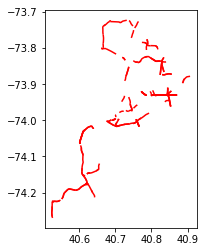

In [8]:
geodf_traffic_links.plot(color='r')
plt.show()

# JOIN TRANSIT STATIONS WITH TRAFFIC LINKS

In [9]:
#LOAD STATION GEO DF (ALREADY PROCESSED IN STATIONS NOTEBOOK)
file = root + 'transit/Stations_geomerged.geojson'
geodf_stations = GeoDataFrame.from_file(file)[['STATION','geometry']]
geodf_stations.head()

,STATION,geometry
0,None,"POLYGON ((40.785036 -73.91203400000001, 40.784..."
1,ASTORIA BLVD,"POLYGON ((40.780258 -73.917843, 40.78020984726..."
2,30 AV,"POLYGON ((40.776779 -73.92147900000001, 40.776..."
3,BROADWAY,"POLYGON ((40.77182 -73.92550799999999, 40.7717..."
4,36 AV,"POLYGON ((40.766804 -73.929575, 40.76675584726..."


In [10]:
geodf_trststns_trfclinks = sjoin(geodf_stations,geodf_traffic_links,how='inner',op='intersects')

In [11]:
geodf_trststns_trfclinks = geodf_trststns_trfclinks.rename(columns={'index_right':'LINK_ID'})
geodf_trststns_trfclinks.info()
geodf_trststns_trfclinks.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 641 entries, 0 to 537
Data columns (total 4 columns):
STATION     532 non-null object
geometry    641 non-null object
LINK_ID     641 non-null int64
BOROUGH     641 non-null object
dtypes: int64(1), object(3)
memory usage: 25.0+ KB


,STATION,geometry,LINK_ID,BOROUGH
0,None,"POLYGON ((40.785036 -73.91203400000001, 40.784...",4456481,Queens
1,ASTORIA BLVD,"POLYGON ((40.780258 -73.917843, 40.78020984726...",4456481,Queens
2,30 AV,"POLYGON ((40.776779 -73.92147900000001, 40.776...",4456481,Queens
0,None,"POLYGON ((40.785036 -73.91203400000001, 40.784...",4456477,Queens
1,ASTORIA BLVD,"POLYGON ((40.780258 -73.917843, 40.78020984726...",4456477,Queens


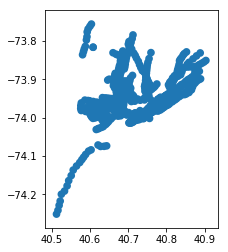

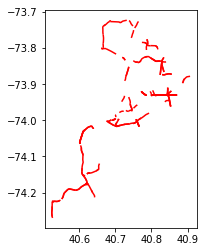

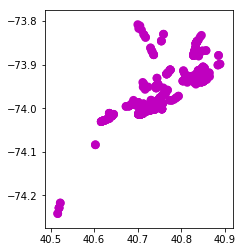

In [12]:
geodf_stations.plot()
geodf_traffic_links.plot(color='r')
geodf_trststns_trfclinks.plot(color='m')
plt.show()

In [13]:
geodf_trststns_trfclinks.to_file(root+'traffic/Traffic_Links_geomerged.geojson',driver='GeoJSON')